In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
import sys
sys.path.append("../src/")
sys.path.append("D:/metabolome_inference/metabolome_inference/src/")
from PeakDetective import rawData,PeakDetective,Classifier,Smoother,normalizeMatrix,safeNormalize
import detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met

In [2]:
datadir = "../data/covid_plasma/"
resolution = 60

In [3]:
ms1ppm = 30
peakWidth = (10,83)
s2n = 5
noise = 500
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
peakList["rt"] = .5 * peakList["rt_start"] + .5 * peakList["rt_end"]
peakList = peakList[["mz","rt"]]
peakList

,mz,rt
1,52.995260,5.082550
2,54.977009,5.083667
3,55.019199,6.030133
4,57.034543,5.399525
5,57.034540,1.583142
...,...,...
3928,1612.974731,6.589500
3929,1612.974770,2.198033
3930,1613.978781,15.015317
3931,1613.978738,2.198033


In [4]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


In [5]:
integ = PeakDetective(numCores = 20,resolution=resolution)

In [6]:
Smoother(resolution).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60)]              0         
                                                                 
 reshape_3 (Reshape)         (None, 60, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 58, 32)            128       
                                                                 
 conv1d_7 (Conv1D)           (None, 56, 16)            1552      
                                                                 
 conv1d_8 (Conv1D)           (None, 54, 8)             392       
                                                                 
 conv1d_9 (Conv1D)           (None, 52, 4)             100       
                                                                 
 flatten_3 (Flatten)         (None, 208)               0   

In [ ]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)

In [40]:
peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [7]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [8]:
peakList_labeled

,mz,rt,classification
3714,779.422724,0.934800,1.0
839,163.043705,0.918175,1.0
2305,307.263816,0.826750,1.0
628,138.873950,5.057608,1.0
573,133.050540,1.415567,1.0
...,...,...,...
3737,824.307493,0.910983,1.0
2441,333.166292,4.351075,1.0
18,59.013809,2.540158,0.0
1235,199.059813,5.071783,0.0


In [9]:
peakList

,mz,rt
1,52.995260,5.082550
2,54.977009,5.083667
3,55.019199,6.030133
4,57.034543,5.399525
5,57.034540,1.583142
...,...,...
3928,1612.974731,6.589500
3929,1612.974770,2.198033
3930,1613.978781,15.015317
3931,1613.978738,2.198033


In [10]:
#format X
if __name__ == "__main__":
    ms1_peaks_curated,X_norm,X_orig,tics,scores,progress,peak_scores = integ.curatePeaks(raw_data,peakList,min_peaks=50000,shift=2.0,smooth_epochs=10,threshold=0.99)

22/22 [==============================] - 0s 3ms/step
done
training classifier...
Epoch 1/10
498/498 [==============================] - 3s 5ms/step - loss: 0.7323 - mean_absolute_error: 0.4936 - val_loss: 0.9409 - val_mean_absolute_error: 0.6871
Epoch 2/10
498/498 [==============================] - 2s 5ms/step - loss: 0.6034 - mean_absolute_error: 0.3950 - val_loss: 0.7596 - val_mean_absolute_error: 0.5307
Epoch 3/10
498/498 [==============================] - 2s 5ms/step - loss: 0.3473 - mean_absolute_error: 0.1671 - val_loss: 0.4572 - val_mean_absolute_error: 0.2396
Epoch 4/10
498/498 [==============================] - 2s 5ms/step - loss: 0.2148 - mean_absolute_error: 0.0913 - val_loss: 0.3515 - val_mean_absolute_error: 0.1709
Epoch 5/10
498/498 [==============================] - 2s 5ms/step - loss: 0.1750 - mean_absolute_error: 0.0747 - val_loss: 0.3123 - val_mean_absolute_error: 0.1489
Epoch 6/10
498/498 [==============================] - 2s 5ms/step - loss: 0.1595 - mean_absolute_er

In [11]:
ms1_peaks_curated

{'../data/covid_plasma/B1_NIST1950_1_6540.mzML':                mz         rt
 2       54.977009   5.083667
 3       55.019199   6.030133
 4       57.034543   5.399525
 5       57.034540   1.583142
 6       56.995904  13.078800
 ...           ...        ...
 3911  1134.336721   7.701983
 3912  1144.635590  13.056317
 3914  1175.773152   0.919300
 3915  1176.777577   0.917967
 3932  1614.976147   2.198033
 
 [2829 rows x 2 columns],
 '../data/covid_plasma/B1_NIST1950_2_6540.mzML':                mz         rt
 2       54.977009   5.083667
 3       55.019199   6.030133
 5       57.034540   1.583142
 6       56.995904  13.078800
 8       56.995787   0.645000
 ...           ...        ...
 3923  1612.976393  14.998683
 3929  1612.974770   2.198033
 3930  1613.978781  15.015317
 3931  1613.978738   2.198033
 3932  1614.976147   2.198033
 
 [2880 rows x 2 columns],
 '../data/covid_plasma/B1_NIST1950_3_6540.mzML':                mz         rt
 2       54.977009   5.083667
 3       55.019199  

[11796, 1141, 897, 807, 750]


Text(0, 0.5, 'log10(# of uncertain peaks)')

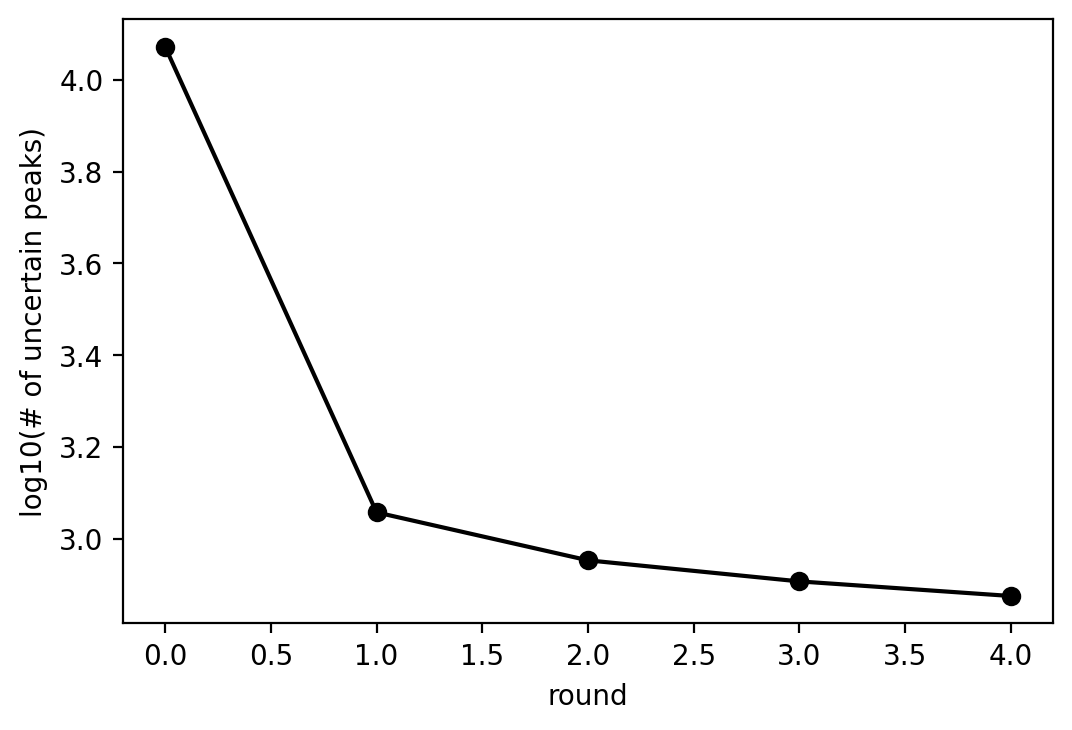

In [12]:
print(progress)
plt.plot(list(range(len(progress))),np.log10(progress),color="black")
plt.scatter(list(range(len(progress))),np.log10(progress),color="black")
plt.xlabel("round")
plt.ylabel("log10(# of uncertain peaks)")

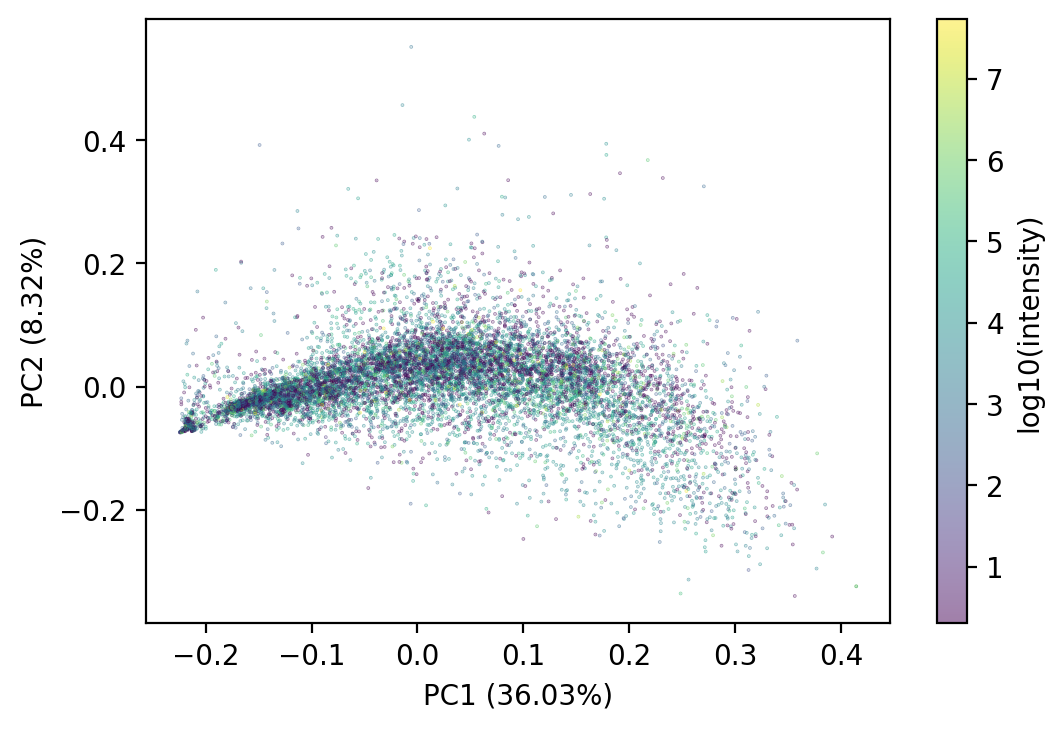

In [13]:
pca = PCA(2)
loads = pca.fit_transform(X_orig)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

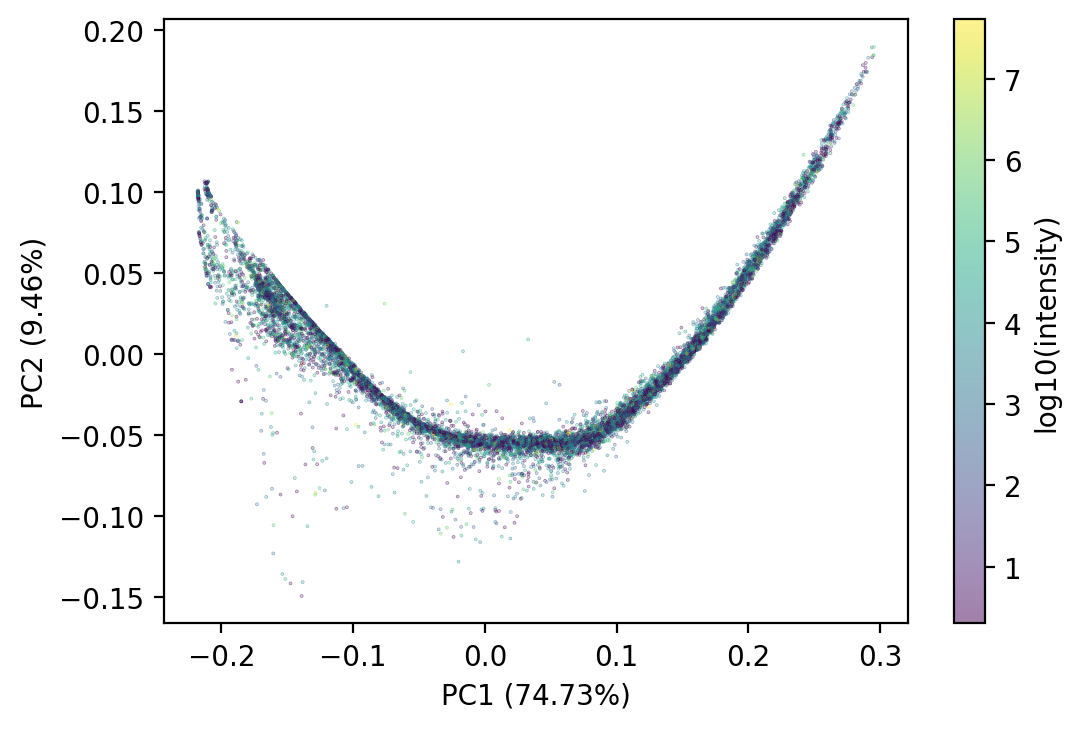

In [14]:
pca = PCA(2)
loads = pca.fit_transform(X_norm)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

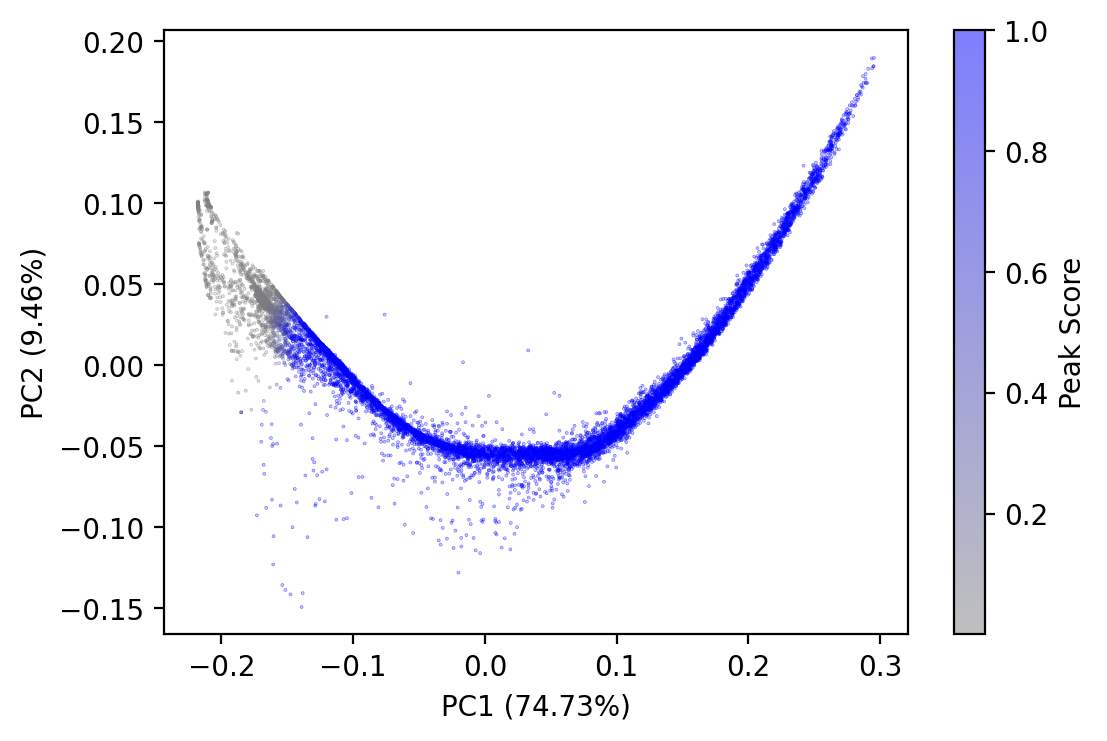

In [15]:
pca = PCA(2)
loads = pca.fit_transform(X_norm)
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=scores,s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="Peak Score")

Text(0, 0.5, '% of features')

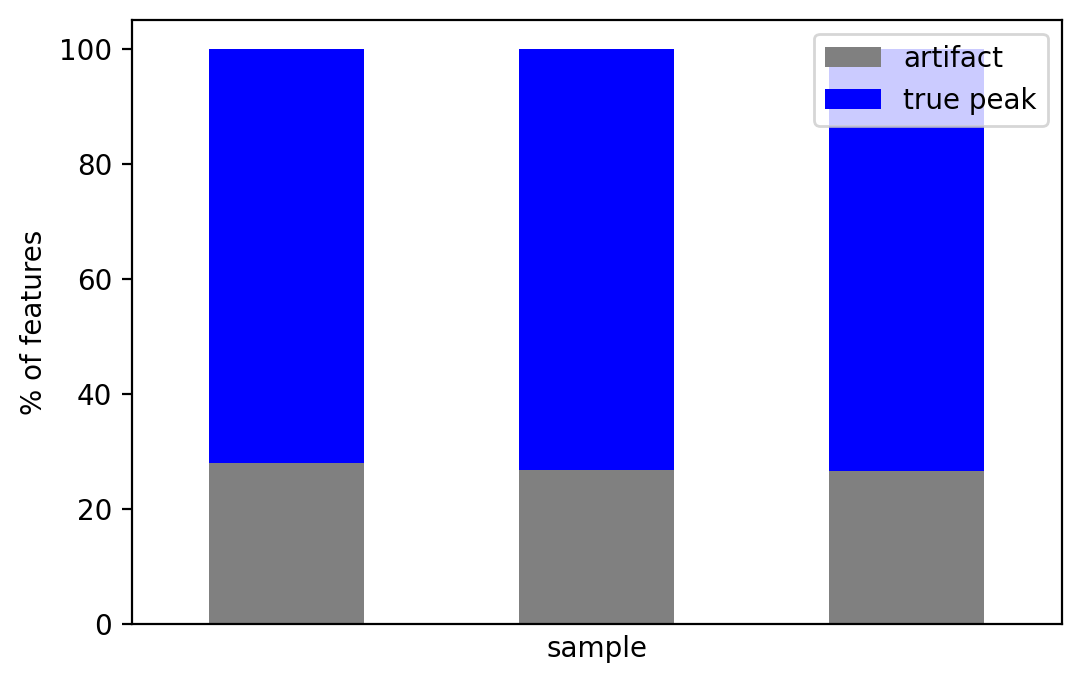

In [16]:
df = {}
for file in files:
    for index,row in peakList.iterrows():
        if index in ms1_peaks_curated[datadir + file].index.values:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


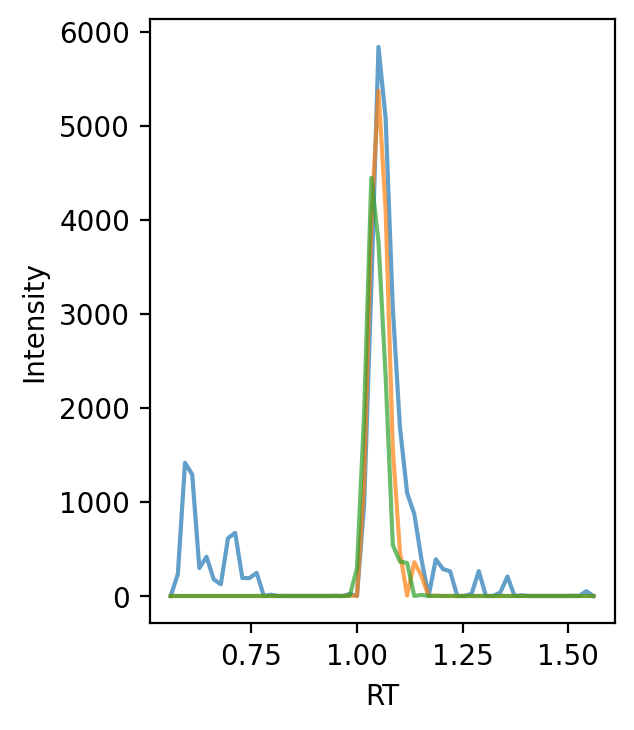

In [17]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = datadir + files[0]
print(files)
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if i in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,ms1_peaks_curated[file].at[i,"mz"],ms1_peaks_curated[file].at[i,"rt"]-.5,ms1_peaks_curated[file].at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

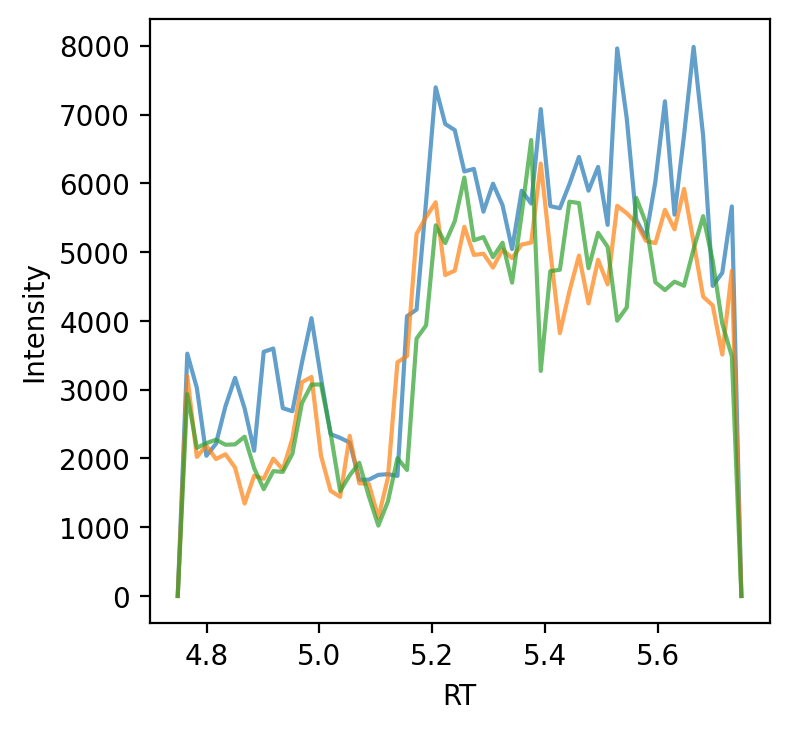

In [18]:
file = datadir + files[0]
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(4,4))

for i in inds:
    if i not in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,peakList.at[i,"mz"],peakList.at[i,"rt"]-.5,peakList.at[i,"rt"] + .5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

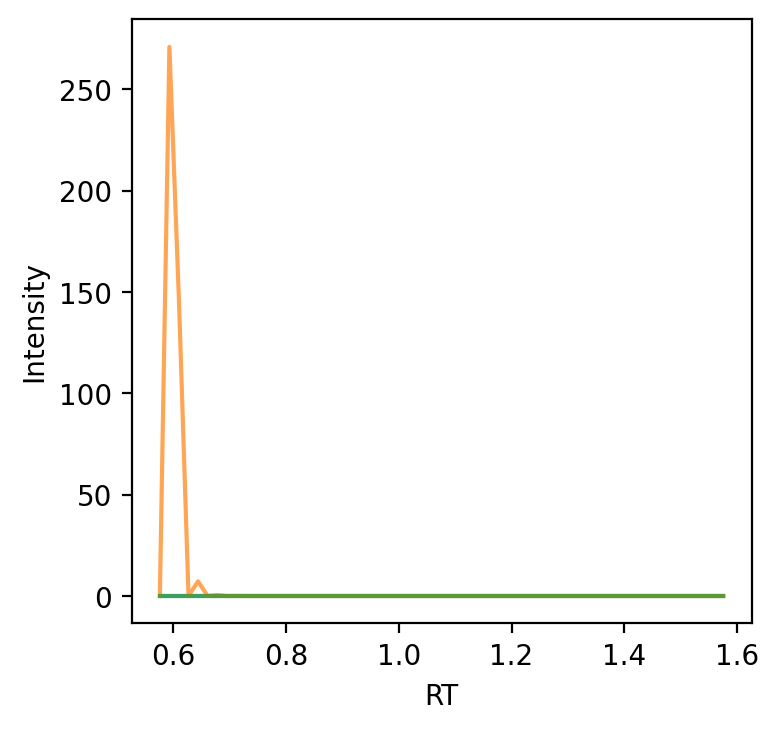

In [19]:
file = datadir + files[0]
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(4,4))

for i in inds:
    if i not in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,peakList.at[i,"mz"],peakList.at[i,"rt"]-.5,peakList.at[i,"rt"] + .5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [20]:
true = []
pred = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    if index in ms1_peaks_curated[datadir + file].index.values:
        pred.append(1.0)
    else:
        pred.append(0.0)
    true.append(row["classification"])
confusion_matrix(true,pred)



array([[130,  74],
       [ 16, 280]], dtype=int64)

In [21]:
peak_scores

,mz,rt,../data/covid_plasma/B1_NIST1950_1_6540.mzML,../data/covid_plasma/B1_NIST1950_2_6540.mzML,../data/covid_plasma/B1_NIST1950_3_6540.mzML
1,52.995260,5.082550,0.010602,0.010602,1.060176e-02
2,54.977009,5.083667,1.000000,1.000000,9.999999e-01
3,55.019199,6.030133,0.999428,0.999931,9.996904e-01
4,57.034543,5.399525,0.997481,0.483372,9.992751e-01
5,57.034540,1.583142,0.999974,0.999997,9.999844e-01
...,...,...,...,...,...
3928,1612.974731,6.589500,0.506305,0.022481,2.916775e-03
3929,1612.974770,2.198033,0.003749,0.999995,7.663141e-03
3930,1613.978781,15.015317,0.007249,0.999999,4.661038e-02
3931,1613.978738,2.198033,0.001318,0.999997,3.634026e-03


0.9415

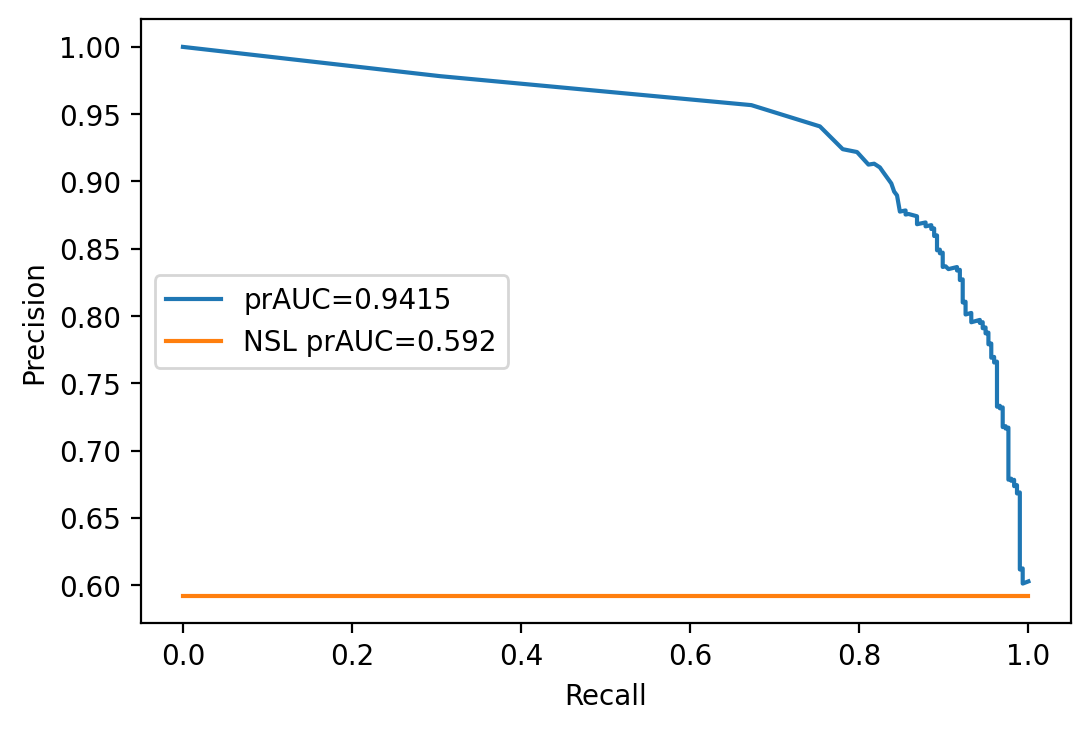

In [22]:
def makePRCPlot(pred,true,noSkill=True):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label="prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

true = []
pred = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    pred.append(peak_scores.at[index,datadir+file])
    true.append(row["classification"])

makePRCPlot(pred,true)

In [23]:
if __name__ == "__main__":
    ms1_peaks_recurse = {}
    for x in range(len(files)):
        rois = integ.roiDetection(raw_data[x],intensityCutuff=1000,numDataPoints=5)
        ms1_peaks_recurse[files[x]] = integ.detectPeaks(raw_data[x],rois,window=10,cutoff = 0.99,noiseCutoff=4.0)
        

Detecting ROIs |█████████████████████████████████████████████████-| 99.8% 1833 ROIs found
1832  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\PeakDetective\__init__.py:561: RuntimeWarning: divide by zero encountered in log10
  ticsOrig = np.log10(np.array([np.sum(x) for x in X]))
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\PeakDetective\__init__.py:561: RuntimeWarning: invalid value encountered in log10
  ticsOrig = np.log10(np.array([np.sum(x) for x in X]))


done,  239992  EICs generated
smoothing EICs...
7500/7500 [==============================] - 54s 7ms/step
done
classifying peaks...
7500/7500 [==============================] - 12s 2ms/step
done
2431  peaks found
Detecting ROIs |█████████████████████████████████████████████████-| 99.8% 1656 ROIs found
1658  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done,  217198  EICs generated
smoothing EICs...
6788/6788 [==============================] - 50s 7ms/step
done
classifying peaks...
6788/6788 [==============================] - 11s 2ms/step
done
2153  peaks found
Detecting ROIs |█████████████████████████████████████████████████-| 99.8% 1670 ROIs found
1670  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done,  218770  EICs generated
smoothing EICs...
6837/6837 [==============================] - 48s 7ms/step
done
classifying peaks...
6837/6837 

In [24]:
ms1_peaks_recurse

{'B1_NIST1950_1_6540.mzML':                mz         rt     score
 0       52.979819   5.056117  1.000000
 1       54.977003   5.056117  1.000000
 2       56.995793   0.722783  0.999965
 3       56.995793  13.056117  0.999998
 4       56.995793  17.222783  0.999530
 ...           ...        ...       ...
 2426  1069.285711   7.389450  0.999999
 2427  1069.285711   7.556117  0.995334
 2428  1101.973330   0.222783  0.998777
 2429  1101.973330   0.389450  0.998436
 2430  1419.983150   0.389450  0.996348
 
 [2431 rows x 3 columns],
 'B1_NIST1950_2_6540.mzML':                mz         rt     score
 0       52.979808   5.053433  1.000000
 1       54.976993   5.053433  1.000000
 2       56.995805   0.720100  0.999959
 3       56.995805  13.053433  0.999994
 4       56.995805  16.720100  0.999976
 ...           ...        ...       ...
 2148  1419.982878   0.386767  0.992561
 2149  1612.974279   2.220100  0.999996
 2150  1612.974279  15.053433  1.000000
 2151  1613.977752   2.220100  0.99999

In [26]:

#X_tot = self.makeDataMatrix([rawData],rois,rt_starts,rt_ends,0)
if __name__ == "__main__":

    uniqueFeatures = {}
    mzTol = 20
    rtTol = 10/60

    labels = []
    X_all = []

    for x in range(len(files)):
        print(x)
        xcms_peaks_curated = ms1_peaks_curated[datadir + files[x]]
        tmp = [x for x in peakList.index.values if x not in xcms_peaks_curated.index.values]
        xcms_peaks_not_curated = peakList.loc[tmp,:]
        inXCMS = []
        for index,row in ms1_peaks_recurse[files[x]].iterrows():
            minMz = row["mz"] - mzTol * row["mz"] / 1e6
            maxMz = row["mz"] + mzTol * row["mz"] / 1e6
            unique = True
            for index2,row2 in peakList.iterrows():
                if row2["mz"] > minMz and row2['mz'] < maxMz:
                    if np.abs(row2["rt"] - row["rt"]):
                        unique = False
                        break

            inXCMS.append(not unique)

        ms1_peaks_recurse[files[x]]["found in xcms"] = inXCMS

        newFeats = ms1_peaks_recurse[files[x]][ms1_peaks_recurse[files[x]]["found in xcms"] == False]

        tmp = integ.makeDataMatrix([raw_data[x]],xcms_peaks_not_curated["mz"].values,xcms_peaks_not_curated["rt"].values - .5, xcms_peaks_not_curated["rt"].values + .5)
        X_all += list(tmp)
        labels += [0 for _ in range(len(tmp))]

        tmp = integ.makeDataMatrix([raw_data[x]],xcms_peaks_curated["mz"].values,xcms_peaks_curated["rt"].values - .5, xcms_peaks_curated["rt"].values + .5)
        X_all += list(tmp)
        labels += [1 for _ in range(len(tmp))]

        tmp = integ.makeDataMatrix([raw_data[x]],newFeats["mz"].values,newFeats["rt"].values - .5, newFeats["rt"].values + .5)
        X_all += list(tmp)
        labels += [2 for _ in range(len(tmp))]

0
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
1
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
2
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


In [27]:
X_all_norm = integ.smoother.predict(normalizeMatrix(X_all))

393/393 [==============================] - 3s 7ms/step


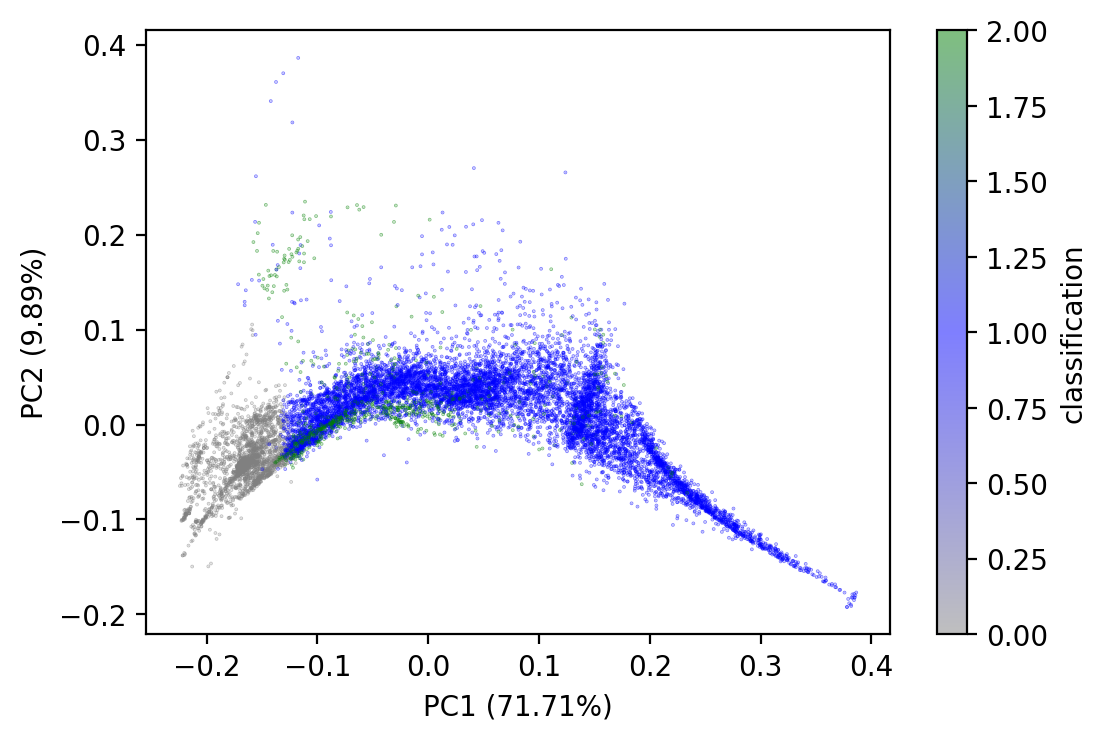

In [28]:
pca = PCA(2)
loads = pca.fit_transform(X_all_norm)
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue","green"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=labels,s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="classification")
#plt.xlim((-2,2))
#plt.ylim((-2,2))

,XCMS artifact,XCMS true peak,PeakDetective recovered
sample,,,
B1_NIST1950_1_6540.mzML,26.236917,67.293054,6.470029
B1_NIST1950_2_6540.mzML,25.197605,68.982036,5.820359
B1_NIST1950_3_6540.mzML,24.928503,68.779790,6.291706


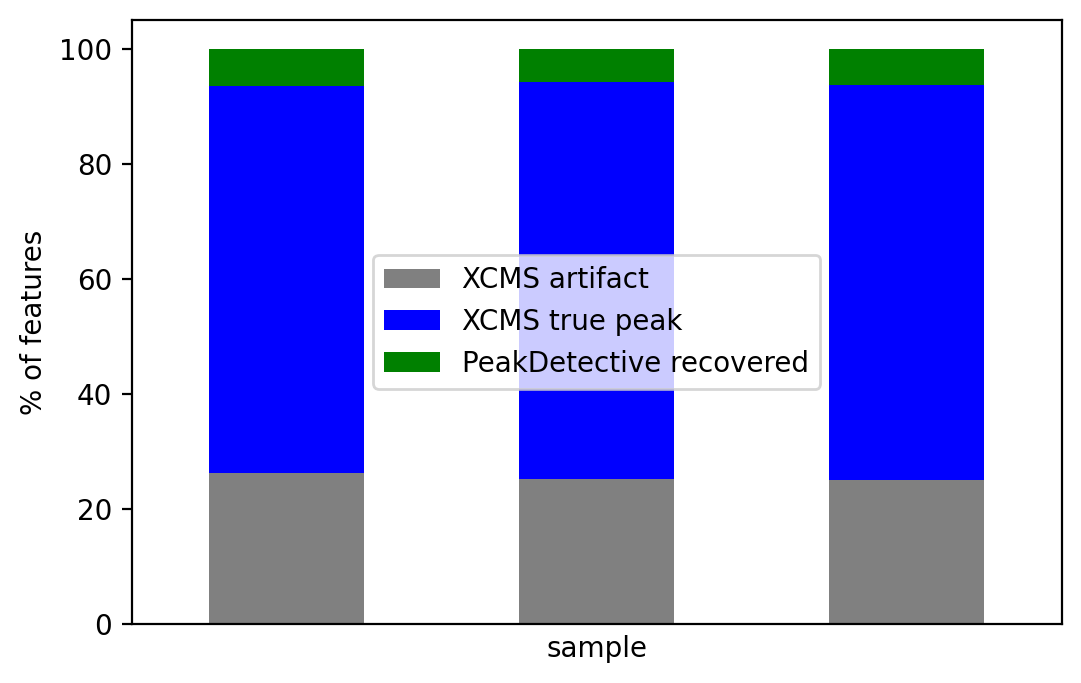

In [29]:
df = {}
for x in range(len(files)):
    xcms_peaks_curated = ms1_peaks_curated[datadir + files[x]]
    tmp = [x for x in peakList.index.values if x not in xcms_peaks_curated.index.values]
    xcms_peaks_not_curated = peakList.loc[tmp,:]
    for _ in range(len(xcms_peaks_not_curated)):
        df[len(df)] = {"sample":files[x],"classification":"XCMS artifact"}

    tmp = ms1_peaks_curated[datadir + files[x]]
    for _ in range(len(tmp)):
        df[len(df)] = {"sample":files[x],"classification":"XCMS true peak"} 
        
    tmp = ms1_peaks_recurse[files[x]][ms1_peaks_recurse[files[x]]["found in xcms"] == False]
    for _ in range(len(tmp)):
        df[len(df)] = {"sample":files[x],"classification":"PeakDetective recovered"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue","green"])
plt.xticks([],[])
plt.ylabel("% of features")
aggregate('sample','classification',df)

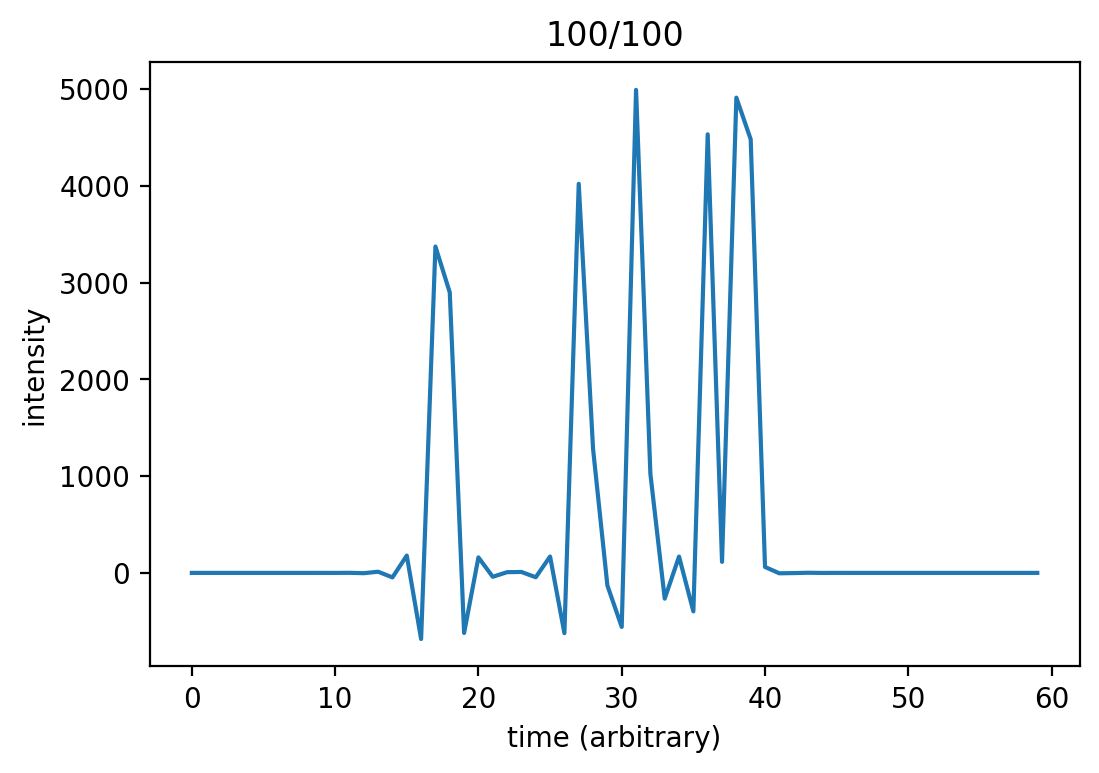

Enter classification (1=True Peak, 0=Artifact): 
0


In [31]:
if __name__ == "__main__":
    tmp = ms1_peaks_recurse[files[0]][ms1_peaks_recurse[files[0]]["found in xcms"] == False]
    inds = list(tmp.index.values)
    inds = rd.sample(inds,100)
    tmp = tmp.loc[inds,:]
    print(tmp)
    peakList_recurse_labeled = integ.label_peaks(raw_data[0],tmp)

In [32]:
peakList_recurse_labeled[peakList_recurse_labeled["classification"] < 0.5]

,mz,rt,score,found in xcms,classification
98,94.985560,12.556117,0.999998,False,0.0
1250,265.147389,5.889450,0.998555,False,0.0
1337,287.186228,1.222783,0.999967,False,0.0
1993,497.384951,0.889450,0.999993,False,0.0
1593,351.312063,17.222783,0.999756,False,0.0
1716,397.167468,1.056117,0.999999,False,0.0
963,218.920716,13.056117,0.999995,False,0.0
1410,301.200746,1.222783,0.991240,False,0.0
1088,236.005058,4.222783,0.999999,False,0.0
1694,389.280932,0.889450,0.999998,False,0.0


In [33]:
true = []
pred = []
file = files[0]
for index,row in peakList_recurse_labeled.iterrows():
    pred.append(row["classification"])
    true.append(1.0)
confusion_matrix(true,pred)

array([[ 0,  0],
       [15, 85]], dtype=int64)